#Preprocessing and Training

In [0]:
!pip install transformers
!pip install PyStanfordDependencies
!pip install asciitree

In [0]:
import matplotlib.pyplot as plt
from transformers import BertModel, BertTokenizer, BertForMaskedLM, BertConfig
import torch
%matplotlib inline
%matplotlib notebook

In [0]:
device = torch.device('cpu')
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
config = BertConfig.from_pretrained('bert-base-cased', output_hidden_states=True)
Model = BertModel.from_pretrained('bert-base-cased', config=config)
LAYER_COUNT = 24
FEATURE_COUNT = 1024
Model.to(device)
Model.eval()

In [0]:
import math
def dist(node1, node2):
  return math.sqrt((node1[0] - node2[0])**2 + (node1[1] - node2[1])**2)

def getRoot(node, parents):
  if node == parents[node]:
    return node
  parents[node] = getRoot(parents[node], parents)
  return parents[node]

def unite(node1, node2, parents):
  parents[getRoot(node1, parents)] = parents[getRoot(node2, parents)]

def Min_Spanning_Tree(graph):
  edges = []
  for i in range(len(graph)):
    for j in range(len(graph)):
      if j <= i or colors[i] != colors[j]:
        continue
      edges.append((dist(graph[i], graph[j]), (i, j)))

  parents = []
  for i in range(len(graph)):
    parents.append(i)
  
  tree = []
  for edge in sorted(edges):
    node1, node2 = edge[1]
    if getRoot(node1, parents) != getRoot(node2, parents):
      tree.append(edge[1])
      unite(node1, node2, parents)

  return tree
  

In [0]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib import collections  as mc
%matplotlib inline

def PCA_projection(x, text):
  x = StandardScaler().fit_transform(x)
  pca = PCA(n_components=2)
  principalComponents = pca.fit_transform(x)

  tree = Min_Spanning_Tree(principalComponents)

  fig = plt.figure(figsize = (8,8))
  ax = fig.add_subplot(1,1,1) 

  for i, node in enumerate(principalComponents):
    ax.scatter(node[0], node[1])

  for i, node in enumerate(principalComponents):
    ax.annotate(text[i], (node[0], node[1]))

  lines = []
  for pair in tree:
    lines.append([principalComponents[pair[0]], principalComponents[pair[1]]])


  lc = mc.LineCollection(lines, linewidths=1)
  ax.add_collection(lc)
  ax.autoscale()
  
# ax.grid()

In [0]:
%%bash
git clone https://github.com/john-hewitt/structural-probes/
cd structural-probes
bash ./download_example.sh
conda install --file requirements.txt
pip install pytorch-pretrained-bert
chmod +rwx download_example.sh

In [0]:
import os

os.chdir('/content/structural-probes/structural-probes') 

import data
import loss
import model
import probe
import regimen
import reporter
import task
import run_experiment
import run_demo

os.chdir('/content/') 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
import yaml
import torch

class SomeClass():
  def __init__(self):
    #path to args.yaml
    self.experiment_config = '/content/args(1).yaml'
    self.results_dir = ''
    self.train_probe = -1
    self.report_results = 1
    self.seed = 0

yaml_args = yaml.load(open('/content/args(1).yaml'))
yaml_args['device'] = torch.device("cpu")

cli_args = SomeClass()
run_experiment.setup_new_experiment_dir(cli_args, yaml_args, cli_args.results_dir)
run_experiment.execute_experiment(yaml_args, train_probe=cli_args.train_probe, report_results=cli_args.report_results)

In [0]:
pathToPredictorParams = '/content/structural-probes/example/results/BERT-disk-parse-distance-2020-5-18-13-37-33-53898/predictor.params'
yaml_args['probe']['distance_params_path'] = pathToPredictorParams

distance_probe = probe.TwoWordPSDProbe(yaml_args)
distance_probe.load_state_dict(torch.load(yaml_args['probe']['distance_params_path'], map_location=yaml_args['device']))

Constructing TwoWordPSDProbe


<All keys matched successfully>

#Visualizing of the text

In [0]:
def splitIntoSent(text):
  sentences = []
  Sentence = []
  for i in text:
    Sentence.append(i)
    if i == '.':
      sentences.append(Sentence)
      Sentence = []
  return sentences

def clasify():
  colors = []
  cnt = 0
  for sent in splitIntoSent(untokenized_sent):
    for i in range(len(sent)):
      colors.append(cnt)
    cnt += 1
  return colors

['Factory', 'payrolls', 'fell', 'in', 'September', '.', 'So', 'did', 'the', 'Federal', 'Reserve', 'Board', "'s", 'industrial-production', 'index', '.', 'This', 'time', ',', 'it', 'was', 'for', 'dinner', 'and', 'dancing', '--', 'a', 'block', 'away', '.']


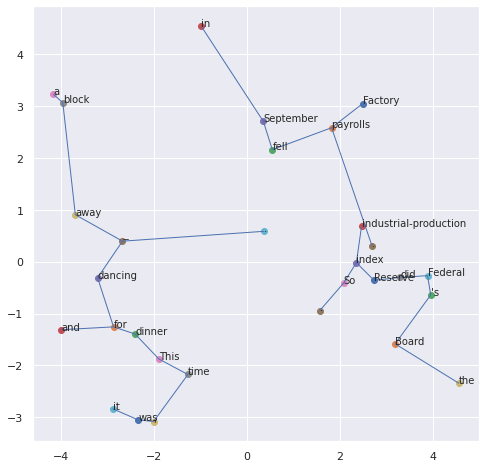

In [0]:
import numpy as np

line = "Factory payrolls fell in September . So did the Federal Reserve Board 's industrial-production index . This time , it was for dinner and dancing -- a block away ."
untokenized_sent = line.strip().split()
tokenized_sent = tokenizer.wordpiece_tokenizer.tokenize('[CLS] ' + ' '.join(line.strip().split()) + ' [SEP]')
print(untokenized_sent)
untok_tok_mapping = data.SubwordDataset.match_tokenized_to_untokenized(tokenized_sent, untokenized_sent)

indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_sent)
segment_ids = [1 for x in tokenized_sent]

tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segment_ids])

tokens_tensor = tokens_tensor.to(yaml_args['device'])
segments_tensors = segments_tensors.to(yaml_args['device'])

with torch.no_grad():
  encoded_layers = Model(tokens_tensor, attention_mask=segments_tensors)
  single_layer_features = encoded_layers[2][yaml_args['model']['model_layer'] + 1]
  representation = [torch.mean(single_layer_features[0,untok_tok_mapping[i][0]:untok_tok_mapping[i][-1]+1,:], dim=0) for i in range(len(untokenized_sent))]

  transformed = []
  for i in range(len(representation)):
    transformed.append(np.dot(representation[i], distance_probe.proj.detach().numpy()))

  colors = clasify()
  PCA_projection(transformed, untokenized_sent)

PCA projection of BERT large model from hugging face.

#Parse Tree of the given text

In [0]:
import StanfordDependencies
sd = StanfordDependencies.get_instance(backend='subprocess')

test = [
"""( (S 
    (NP-SBJ (NN Factory) (NNS payrolls) )
    (VP (VBD fell) 
      (PP-TMP (IN in) 
        (NP (NNP September) )))
    (. .) ))""",
"""( (SINV 
    (ADVP-PRD-TPC-1 (RB So) )
    (VP (VBD did) 
      (VP (-NONE- *?*) 
        (ADVP-PRD (-NONE- *T*-1) )))
    (NP-SBJ 
      (NP (DT the) (NNP Federal) (NNP Reserve) (NNP Board) (POS 's) )
      (JJ industrial-production) (NN index) )
    (. .) ))""",
"""( (S 
    (NP-TMP (DT This) (NN time) )
    (, ,) 
    (NP-SBJ (PRP it) )
    (VP (VBD was) 
      (PP-PRD (IN for) 
        (NP 
          (NP (NN dinner) 
            (CC and)
            (NN dancing) )
          (: --) 
          (ADVP-LOC 
            (NP (DT a) (NN block) )
            (RB away) ))))
    (. .) ))
"""]

convertedText = [sd.convert_tree(data) for data in test]

In [0]:
print(convertedText[0].as_asciitree())
print(convertedText[1].as_asciitree())
print(convertedText[2].as_asciitree())

 fell [root]
  +-- payrolls [nsubj]
  |  +-- Factory [compound]
  +-- September [nmod]
  |  +-- in [case]
  +-- . [punct]
 did [root]
  +-- So [advmod]
  +-- index [nsubj]
  |  +-- Board [nmod:poss]
  |  |  +-- the [det]
  |  |  +-- Federal [compound]
  |  |  +-- Reserve [compound]
  |  |  +-- 's [case]
  |  +-- industrial-production [amod]
  +-- . [punct]
 dinner [root]
  +-- time [nmod:tmod]
  |  +-- This [det]
  +-- , [punct]
  +-- it [nsubj]
  +-- was [cop]
  +-- for [case]
  +-- and [cc]
  +-- dancing [conj]
  +-- -- [punct]
  +-- away [advmod]
  |  +-- block [nmod:npmod]
  |     +-- a [det]
  +-- . [punct]


# Training structural probe


In [0]:
!curl --remote-name-all https://lindat.mff.cuni.cz/repository/xmlui/bitstream/handle/11234/1-3105{/ud-treebanks-v2.5.tgz,/ud-documentation-v2.5.tgz,/ud-tools-v2.5.tgz}
!tar -xvf /content/ud-treebanks-v2.5.tgz

In [0]:
%%bash
rm -rf /content/structural-probes/example/data/en_ewt-ud-sample
mkdir /content/structural-probes/example/data/en_ewt-ud-sample
mkdir /content/structural-probes/example/data/en-ewt-ud-sample-bert
mv /content/ud-treebanks-v2.5/UD_English-EWT/en_ewt-ud-dev.conllu /content/structural-probes/example/data/en_ewt-ud-sample
mv /content/ud-treebanks-v2.5/UD_English-EWT/en_ewt-ud-test.conllu /content/structural-probes/example/data/en_ewt-ud-sample
mv /content/ud-treebanks-v2.5/UD_English-EWT/en_ewt-ud-train.conllu /content/structural-probes/example/data/en_ewt-ud-sample
rm -rf /content/ud-treebanks-v2.5
rm /content/ud-documentation-v2.5.tgz
rm /content/ud-tools-v2.5.tgz
rm /content/ud-treebanks-v2.5.tgz

In [0]:
%%writefile /content/structural-probes/scripts/convert_conll_to_raw.py
import sys
import argparse

argp = argparse.ArgumentParser()
argp.add_argument('input_conll_filepath')
argp.add_argument('output_filepath')
args = argp.parse_args()

buf = []
f = open(args.output_filepath, 'w')
for line in open(args.input_conll_filepath):
  if line.startswith('#'):
    continue
  if not line.strip():
    f.write(' '.join(buf) + '\n')
    buf = []
  else:
    buf.append(line.split('\t')[1])
if buf:
    f.write(' '.join(buf) + '\n')
f.close()


Overwriting /content/structural-probes/scripts/convert_conll_to_raw.py


In [0]:
%%bash
python3 /content/structural-probes/scripts/convert_conll_to_raw.py /content/structural-probes/example/data/en_ewt-ud-sample/en_ewt-ud-dev.conllu /content/structural-probes/example/data/en_ewt-ud-sample/en_ewt-ud-dev.txt
python3 /content/structural-probes/scripts/convert_conll_to_raw.py /content/structural-probes/example/data/en_ewt-ud-sample/en_ewt-ud-test.conllu /content/structural-probes/example/data/en_ewt-ud-sample/en_ewt-ud-test.txt 
python3 /content/structural-probes/scripts/convert_conll_to_raw.py /content/structural-probes/example/data/en_ewt-ud-sample/en_ewt-ud-train.conllu /content/structural-probes/example/data/en_ewt-ud-sample/en_ewt-ud-train.txt 

In [0]:
%%bash
cd /content/structural-probes/scripts
python3 convert_raw_to_bert.py /content/structural-probes/example/data/en_ewt-ud-sample/en_ewt-ud-dev.txt /content/structural-probes/example/data/en-ewt-ud-sample-bert/en_ewt-ud-dev.hdf5 base

The pre-trained model you are loading is a cased model but you have not set `do_lower_case` to False. We are setting `do_lower_case=False` for you but you may want to check this behavior.


In [0]:
%%bash
cd /content/structural-probes/scripts
python3 convert_raw_to_bert.py /content/structural-probes/example/data/en_ewt-ud-sample/en_ewt-ud-test.txt /content/structural-probes/example/data/en-ewt-ud-sample-bert/en_ewt-ud-test.hdf5 base

The pre-trained model you are loading is a cased model but you have not set `do_lower_case` to False. We are setting `do_lower_case=False` for you but you may want to check this behavior.


In [0]:
%%bash
cd /content/structural-probes/scripts
python3 convert_raw_to_bert.py /content/structural-probes/example/data/en_ewt-ud-sample/en_ewt-ud-train.txt /content/structural-probes/example/data/en-ewt-ud-sample-bert/en_ewt-ud-train.hdf5 base

The pre-trained model you are loading is a cased model but you have not set `do_lower_case` to False. We are setting `do_lower_case=False` for you but you may want to check this behavior.
